This notebook uses `sktime`


Examples of classification; try just training a CNN versus Random Weights versus raw time series?
+ Justification: TimeNet paper suggests generic feature extractors exist


https://github.com/hfawaz/dl-4-tsc/tree/master/classifiers
https://pyts.readthedocs.io/en/stable/generated/pyts.datasets.load_basic_motions.html

In [16]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *


# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
%%bash --out output --err error

python3 baseline_transfer_learning.py

Process is interrupted.


In [2]:
%%bash --out output --err error

python3 surrogate_transfer_learning.py

Process is interrupted.


In [8]:
import os
cwd = os.getcwd()

In [14]:
import numpy as np
np.genfromtxt(cwd + "/resources/ucr_ea_names.txt", dtype='str')

array(['ACSF1', 'Adiac', 'ArrowHead', 'BME', 'Beef', 'BeetleFly',
       'BirdChicken', 'CBF', 'Car', 'ChlorineConcentration',
       'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY',
       'CricketZ', 'DiatomSizeReduction', 'DodgerLoopDay',
       'DodgerLoopGame', 'DodgerLoopWeekend', 'ECG5000', 'ECGFiveDays',
       'EOGHorizontalSignal', 'EOGVerticalSignal', 'Earthquakes',
       'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords',
       'Fish', 'FordA', 'FordB', 'FreezerRegularTrain',
       'FreezerSmallTrain', 'Fungi', 'GunPoint', 'GunPointAgeSpan',
       'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham',
       'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate',
       'InsectEPGRegularTrain', 'InsectEPGSmallTrain',
       'InsectWingbeatSound', 'LargeKitchenAppliances', 'Lightning2',
       'Lightning7', 'Mallat', 'Meat', 'MixedShapesRegularTrain',
       'MixedShapesSmallTrain', 'NonInvasiveFetalECGThorax1',
       'NonInv

In [17]:
# ?sktime.datasets.load_UCR_UEA_dataset

In [6]:
## Pre-processing: nothing, PCA, rockets, trained rockets


## Featurize: tsfresh, random convolutions, pre-trained AE
## try selecting chaotic systems with the closest power spectrum
from sktime.transformations.panel.rocket import Rocket

model = Rocket()

In [10]:
import torch
from torch import nn

## Benchmarks: 
# tsfresh handcrafted features
# ROCKET: Random convolutional transforms followed by an aggregation operation
# What classifier to use? Just a random forest?

https://github.com/White-Link/UnsupervisedScalableRepresentationLearningTimeSeries/tree/master/networks

In [242]:
# chunk_size = 30


    

    
from dysts.flows import Lorenz

model = Lorenz()

sol = model.make_trajectory(1000, resample=True)

model = Autoencoder()
print(inputs.shape)
print(model.encoder(inputs).shape)
print(model(inputs).shape)

torch.Size([4, 1, 100])
torch.Size([4, 8, 34])
torch.Size([4, 1, 100])


In [236]:
sol.shape

(1000,)

In [233]:
np.unravel_index(90, (7,  (100 - 10)))

(1, 0)

In [226]:
np.ravel_multi_index(0, (7,  (100 - 10)))

TypeError: dispatcher for __array_function__ did not return an iterable

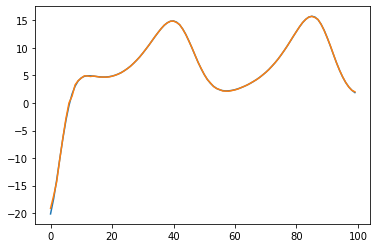

In [243]:


    
# training_data = UnivariateTimeSeries(sol[:, 0], 100)
training_data = TimeSeriesCollection(sol, 100)






model = Autoencoder()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
plt.plot(inputs[0, 0, :].detach().numpy())
plt.plot(outputs[0, 0, :].detach().numpy())

In [ ]:
## Batchwise training classifier
## Baseline is usually 1-NN with DTW
## But really need an NN where we can pre-train
## ROCKET vs trained convolutional?



## Or, unsupervised learning on a bunch of chaotic ssytems
## then train a classifier on the encoder outputs for new data

Classifier: logistic regression and Adam OR Ridge Regression



89

In [304]:
import sktime.datasets
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.linear_model import RidgeClassifierCV

cwd = os.getcwd()
# cwd = os.path.dirname(os.path.realpath(__file__))
output_path = cwd + "/results/transfer_learning.json"
print("Saving data to: ", output_path)

dataset_names = np.genfromtxt("./resources/ucr_ea_names.txt", dtype='str')

all_scores = dict()
for name in dataset_names:
    all_scores[name] = dict()
    X_train, y_train = sktime.datasets.load_UCR_UEA_dataset(name, split="train", return_X_y=True)
    X_test, y_test = sktime.datasets.load_UCR_UEA_dataset(name, split="test", return_X_y=True)
    
    transformer = TSFreshFeatureExtractor()
    X_train_featurized = transformer.fit_transform(X_train)
    X_test_featurized = transformer.fit_transform(X_test)

    model = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
    model.fit(X_train_featurized, y_train)

    score = model.score(X_test_featurized, y_test)
    all_scores[name]["score_tsfresh"] = model.score(X_test_featurized, y_test)

    print(name, score, flush=True)
    
    with open(output_path, 'w') as file:
        json.dump(all_scores, file, indent=4)
    

Saving data to:  /Users/williamgilpin/program_repos/dysts/benchmarks/results/transfer_learning.json


Feature Extraction: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


ACSF1 0.77


Feature Extraction: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__fft_coefficient__attr_"real"__coeff_89'
 'dim_0__fft_coefficient__attr_"real"__coeff_90'
 'dim_0__fft_coefficient__attr_"real"__coeff_91'
 'dim_0__fft_coefficient__attr_"real"__coeff_92'
 'dim_0__fft_coefficient__attr_"real"__coeff_93'
 'dim_0__fft_coefficient__attr_"real"__coeff_94'
 'dim_0__fft_coefficient__attr_"real"__coeff_95'
 'dim_0__fft_coefficient__attr_"real"__coeff_96'
 'dim_0__fft_coefficient__attr_"real"__coeff_97'
 'dim_0__fft_coefficient__attr_"real"__coeff_98'
 'dim_0__fft_coefficient__attr_"real"__coeff_99'
 'dim_0__fft_coefficient__attr_"imag"__coeff_89'
 'dim_0__fft_coefficient__attr_"imag"__coeff_90'
 'dim_0__fft_coefficient__attr_"imag"__coeff_91'
 'dim_0__fft_coefficient__attr_"imag"__coeff_92'
 'dim_0__fft_coefficient__attr_"imag"__coeff_93'
 'dim

Adiac 0.5549872122762148


Feature Extraction: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:34<00:00,  6.91s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


AllGestureWiimoteX 0.6285714285714286


Feature Extraction: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:37<00:00,  7.56s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


AllGestureWiimoteY 0.6542857142857142


Feature Extraction: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:37<00:00,  7.50s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


AllGestureWiimoteZ 0.5157142857142857


Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


ArrowHead 0.6857142857142857


Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__fft_coefficient__attr_"real"__coeff_65'
 'dim_0__fft_coefficient__attr_"real"__coeff_66'
 'dim_0__fft_coefficient__attr_"real"__coeff_67'
 'dim_0__fft_coefficient__attr_"real"__coeff_68'
 'dim_0__fft_coefficient__attr_"real"__coeff_69'
 'dim_0__fft_coefficient__attr_"real"__coeff_70'
 'dim_0__fft_coefficient__attr_"real"__coeff_71'
 'dim_0__fft_coefficient__attr_"real"__coeff_72'
 'dim_0__fft_coefficient__attr_"real"__coeff_73'
 'dim_0__fft_coefficient__attr_"real"__coeff_74'
 'dim_0__fft_coefficient__attr_"real"__coeff_75'
 'dim_0__fft_coefficient__attr_"real"__coeff_76'
 'dim_0__fft_coefficient__attr_"real"__coeff_77'
 'dim_0__fft_coefficient__attr_"real"__coeff_78'
 'dim_0__fft_coefficient__attr_"real"__coeff_79'
 'dim_0__fft_coefficient__attr_"real"__coeff_80'
 'dim

BME 1.0


Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

Beef 0.8666666666666667



/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

BeetleFly 0.8



/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

BirdChicken 0.85



/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__fft_coefficient__attr_"real"__coeff_65'
 'dim_0__fft_coefficient__attr_"real"__coeff_66'
 'dim_0__fft_coefficient__attr_"real"__coeff_67'
 'dim_0__fft_coefficient__attr_"real"__coeff_68'
 'dim_0__fft_coefficient__attr_"real"__coeff_69'
 'dim_0__fft_coefficient__attr_"real"__coeff_70'
 'dim_0__fft_coefficient__attr_"real"__coeff_71'
 'dim_0__fft_coefficient__attr_"real"__coeff_72'
 'dim_0__fft_coefficient__attr_"real"__coeff_

CBF 0.9933333333333333


Feature Extraction: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

Car 0.7166666666666667



/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__fft_coefficient__attr_"real"__coeff_13'
 'dim_0__fft_coefficient__attr_"real"__coeff_14'
 'dim_0__fft_coefficient__attr_"real"__coeff_15'
 'dim_0__fft_coefficient__attr_"real"__coeff_16'
 'dim_0__fft_coefficient__attr_"real"__coeff_17'
 'dim_0__fft_coefficient__attr_"real"__coeff_18'
 'dim_0__fft_coefficient__attr_"real"__coeff_19'
 'dim_0__fft_coefficient__attr_"real"__coeff_20'
 'dim_0__fft_coefficient__attr_"real"__coeff_

Chinatown 0.9737609329446064


Feature Extraction: 100%|██████████| 5/5 [00:35<00:00,  7.04s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__fft_coefficient__attr_"real"__coeff_84'
 'dim_0__fft_coefficient__attr_"real"__coeff_85'
 'dim_0__fft_coefficient__attr_"real"__coeff_86'
 'dim_0__fft_coefficient__attr_"real"__coeff_87'
 'dim_0__fft_coefficient__attr_"real"__coeff_88'
 'dim_0__fft_coefficient__attr_"real"__coeff_89'
 'dim_0__fft_coefficient__attr_"real"__coeff_90'
 'dim_0__fft_coefficient__attr_"real"__coeff_91'
 'dim_0__fft_coefficient__attr_"real"__coeff_92'
 'dim_0__fft_coefficient__attr_"real"__coeff_93'
 'dim_0__fft_coefficient__attr_"real"__coeff_94'
 'dim_0__fft_coefficient__attr_"real"__coeff_95'
 'dim_0__fft_coefficient__attr_"real"__coeff_96'
 'dim_0__fft_coefficient__attr_"real"__coeff_97'
 'dim_0__fft_coefficient__attr_"real"__coeff_98'
 'dim_0__fft_coefficient__attr_"real"__coeff_99'
 'dim

ChlorineConcentration 0.6135416666666667


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [05:46<00:00, 69.28s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


CinCECGTorso 0.8021739130434783


Feature Extraction: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

Coffee 1.0



/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__friedrich_coefficients__coeff_0__m_3__r_30'
 'dim_0__friedrich_coefficients__coeff_1__m_3__r_30'
 'dim_0__friedrich_coefficients__coeff_2__m_3__r_30'
 'dim_0__friedrich_coefficients__coeff_3__m_3__r_30'
 'dim_0__max_langevin_fixed_point__m_3__r_30'
 'dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Fi

Computers 0.716


Feature Extraction: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction:  40%|████      | 2/5 [00:21<00:31, 10.65s/it]


KeyboardInterrupt: 

In [248]:
from dysts.utils import find_significant_frequencies

from sktime.utils.data_processing import from_nested_to_3d_numpy, from_3d_numpy_to_nested

X_train_np = from_nested_to_3d_numpy(X_train)
X_test_np = from_nested_to_3d_numpy(X_test)

all_freqs = list()
for row in X_train_np:
    freqs, amps = find_significant_frequencies(row[0], return_amplitudes=True)
    sort_inds = np.argsort(amps)[::-1]
    freqs, amps = freqs[sort_inds], amps[sort_inds]
    all_freqs.append(freqs[0])
main_freq = np.median(all_freqs)
main_period = 2 * 1/main_freq

all_sols = list()
for equation_ind, equation_name in enumerate(get_attractor_list()):
    equation = getattr(dysts.flows, equation_name)()
    sol = equation.make_trajectory(1000, resample=True, pts_per_period=int(main_period))
    all_sols.append(standardize_ts(sol)[:, 0])
    if equation_ind > 5:
        print("stopped at index")
        break
all_sols = np.array(all_sols).T
# plt.plot(all_sols[:100]);

# plt.plot(row[0][:300])
# plt.plot(sol[:300, 0]/5)




/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")
/Users/williamgilpin/miniconda3/envs/dys

stopped at index


In [255]:
training_data = TimeSeriesCollection(all_sols, 100)

model = Autoencoder()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

In [298]:
X_train_nn = from_3d_numpy_to_nested(model.encoder(torch.tensor(X_train_np, dtype=torch.float32)).detach().numpy())
X_test_nn = from_3d_numpy_to_nested(model.encoder(torch.tensor(X_test_np, dtype=torch.float32)).detach().numpy())

transformer = TSFreshFeatureExtractor()
X_train_featurized = transformer.fit_transform(X_train_nn)
X_test_featurized = transformer.fit_transform(X_test_nn)

model = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
model.fit(X_train_featurized, y_train)

score = model.score(X_test_featurized, y_test)

Feature Extraction: 100%|██████████| 5/5 [02:55<00:00, 35.04s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['var_0__fft_coefficient__attr_"real"__coeff_51'
 'var_0__fft_coefficient__attr_"real"__coeff_52'
 'var_0__fft_coefficient__attr_"real"__coeff_53' ...
 'var_7__fft_coefficient__attr_"angle"__coeff_98'
 'var_7__fft_coefficient__attr_"angle"__coeff_99'
 'var_7__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [02:47<00:00, 33.41s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['var_0__fft_coefficient__attr_"real"__coeff_51'
 'var_0__fft_coefficient__attr_"real"__coeff_52'
 'var_0__fft_coefficien

In [25]:

import numpy as np
import sktime.datasets

dataset_names = np.genfromtxt("./resources/ucr_ea_names.txt", dtype='str')
for name in dataset_names:
#     print(name, flush=True)
    X_train, y_train = sktime.datasets.load_UCR_UEA_dataset(name, split="train", return_X_y=True)
    
#     all_lengths = np.array([len(np.array(item[0])) for item in X_train.values])
#     if np.any(all_lengths != all_lengths[0]):
#         print(name, " x ", flush=True)
#     else:
#         if all_lengths[0] >= 105:
#             print(name)

    any_nan = np.any(np.array([np.any(np.isnan(np.array(item[0]))) for item in X_train.values]))
    if any_nan:
        print(name)

DodgerLoopDay
DodgerLoopGame
DodgerLoopWeekend


## Archive

In [ ]:
from sktime.utils.data_io import load_from_tsfile_to_dataframe


BASE_PATH = "./resources/ucr_univariate_ts"
dataset_names = np.genfromtxt("./resources/ucr_ea_names.txt", dtype='str')

for name in dataset_names:

    X_train, y_train = load_from_tsfile_to_dataframe(
        os.path.join(BASE_PATH, name + "/" + name + "_TRAIN.ts")
    )
    
    X_test, y_test = load_from_tsfile_to_dataframe(
        os.path.join(BASE_PATH, name + "/" + name + "_TEST.ts")
    )

    break


In [ ]:
## use basic motions dataset
from sktime.datasets import load_basic_motions
from sktime.utils.data_processing import from_nested_to_2d_array

X_train = np.array([np.array(item[0]) for item in load_basic_motions(split="train")[["dim_0"]].values])
X_train = standardize_ts(X_train)
y_train = load_basic_motions(split="train")["class_val"].to_list()

X_test = np.array([np.array(item[0]) for item in load_basic_motions(split="test")[["dim_0"]].values])
X_test = standardize_ts(X_test)
y_test = load_basic_motions(split="test")["class_val"].to_list()